In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

In [3]:
def compute_A2(x: np.ndarray, F: callable):
    '''
    x.shape = (n, N) 
        n = sample size
        N = # of samples
    F = cdf of the "true" distribution
    '''
    n = x.shape[0]
    z = F(np.sort(x, axis=0))
    S = np.sum(np.arange(1, 2 * n, 2)[:, None] * (np.log(z) + np.log(1-z[::-1])), axis=0) / n
    return -n - S

simulate = lambda n, N, dist: compute_A2(dist.rvs((n, N)), dist.cdf)

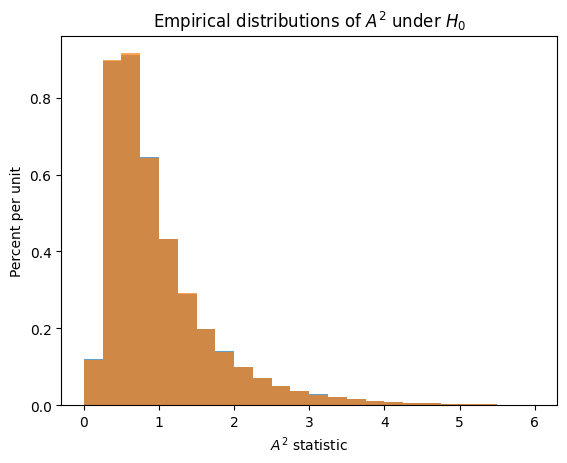

In [4]:
dist1 = scipy.stats.uniform()
dist2 = scipy.stats.expon()

bins = np.arange(0, 6.1, .25)
for dist in [dist1, dist2]:
    statistics = simulate(100, 10**6, dist)
    plt.hist(statistics, density=True, bins=bins, alpha=.7)
plt.xlabel(r'$A^2$ statistic')
plt.ylabel('Percent per unit')
plt.title(r'Empirical distributions of $A^2$ under $H_0$')
plt.show()

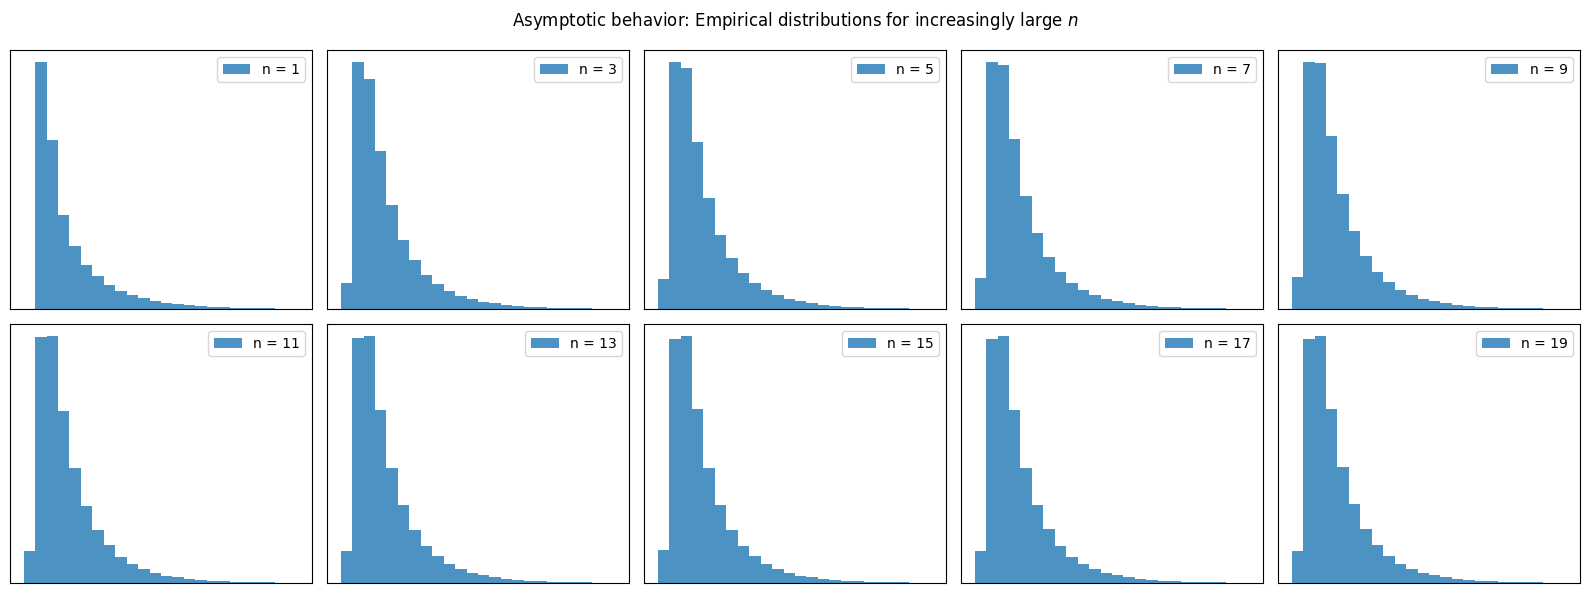

In [5]:
fig, axs = plt.subplots(2, 5, figsize=(16, 6))
for ax, n in zip(axs.flatten(), range(1, 20, 2)):
    statistics = simulate(n, 10**6, dist1)
    ax.hist(statistics, density=True, bins=bins, alpha=.8, label=f'{n = }')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend()
plt.suptitle(r'Asymptotic behavior: Empirical distributions for increasingly large $n$')
plt.tight_layout()
plt.show()

In [6]:
statistics = simulate(100, 10**6, dist1)
np.mean(statistics)

np.float64(1.000016322400621)

In [7]:
@np.vectorize
def evaluate_cdf(z, N):
    '''
    Evaluate the asymptotic cdf at A^2 = z with N terms in the summation
    https://doi.org/10.1214/aoms/1177729437 (pp. 204)
    '''
    @np.vectorize
    def term(j):
        t_j = (4*j+1)**2 * np.pi**2 / (8*z)
        integrand = lambda w: np.exp(z / (8*(1+w**2)) - w**2 * t_j)
        integral = scipy.integrate.quad(integrand, 0, np.inf)[0]
        return integral * scipy.special.binom(-.5, j) * (4*j+1) * np.exp(-t_j)
    return np.sqrt(2 * np.pi) / z * np.sum(term(np.arange(N)))

In [8]:
print(1 - evaluate_cdf(10, 5))
print(1 - 0.999986184964589314168018038088) # https://doi.org/10.18637/jss.v009.i02

1.3815035410646992e-05
1.3815035410646992e-05


In [9]:
print(1 - evaluate_cdf(3, 5))
print(np.mean(statistics > 3))

0.027364788334026335
0.027558


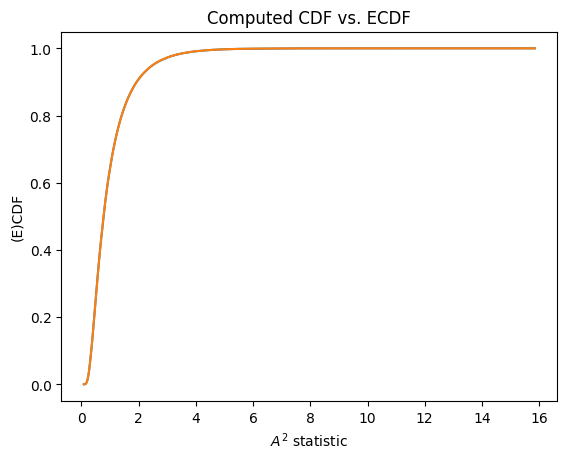

In [10]:
x = np.sort(statistics)
y_empirical = np.linspace(0, 1, statistics.size, endpoint=False)
plt.plot(x, y_empirical)
x_subsample = np.append(x[::100], x[-1])
y_numerical = evaluate_cdf(x_subsample, 5)
plt.plot(x_subsample, y_numerical)
plt.xlabel(r'$A^2$ statistic')
plt.ylabel('(E)CDF')
plt.title('Computed CDF vs. ECDF')
plt.show()

In [11]:
%timeit evaluate_cdf(3, 5)

1.32 ms ± 6.87 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [12]:
z = np.linspace(1, 10, 100)
%timeit evaluate_cdf(z, 5)

42.1 ms ± 403 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
